In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from keras import models
from keras import layers

%matplotlib inline

train = pd.read_csv('/kaggle/input/playground-series-s3e10/train.csv')
train.head(10)

id  Mean_Integrated         SD        EK  Skewness  Mean_DMSNR_Curve  \
0   0       133.171875  59.716081  0.043133 -0.703383         54.917224   
1   1        87.093750  36.257973  0.435469  2.266057          3.417224   
2   2       112.640625  39.818393  0.379639  0.922306          2.730769   
3   3       120.679688  45.918448 -0.098490  0.011775          2.696488   
4   4       134.070312  57.720107 -0.107772 -0.573335          1.107860   
5   5       131.632812  52.563210 -0.075253 -0.495825          2.194816   
6   6       110.937500  41.556955  0.312844  0.559022          1.965719   
7   7       120.203125  49.927902 -0.089990 -0.321367          3.280100   
8   8       112.414062  46.939866  0.282551  0.151784          3.336957   
9   9        99.859375  48.089189  0.693710  0.281663          3.414716   

   SD_DMSNR_Curve  EK_DMSNR_Curve  Skewness_DMSNR_Curve  Class  
0       70.084438        0.749798             -0.649512      0  
1       21.865069        7.039330             52.686251      0  
2       15.689690        8.193471             85.649785      0  
3       20.954662        8.183874             70.332899      0  
4       11.255051       16.107748            308.753765      0  
5       15.537425        9.033439             97.032406      0  
6       17.191469       10.396774            118.724270      0  
7       18.376840        8.190561             77.917237      0  
8       21.929529        7.693330             65.186279      0  
9       24.181910        7.958684             65.084575      0

Extract labels, delet Id column from dataset
Scaling dataet

In [2]:
label = train['Class']

del train['id']
del train['Class']

scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train),columns = train.columns)

train.head(5)

Mean_Integrated        SD        EK  Skewness  Mean_DMSNR_Curve  \
0         0.880240  2.130547 -0.408455 -0.397482          1.607581   
1        -0.969814 -1.713208 -0.060358  0.058273         -0.319826   
2         0.055902 -1.129811 -0.109893 -0.147968         -0.345517   
3         0.378674 -0.130280 -0.534109 -0.287718         -0.346800   
4         0.916312  1.803494 -0.542344 -0.377522         -0.406255   

   SD_DMSNR_Curve  EK_DMSNR_Curve  Skewness_DMSNR_Curve  
0        2.190105       -1.897360             -1.182197  
1       -0.215829       -0.259872             -0.515181  
2       -0.523953        0.040610             -0.102940  
3       -0.261254        0.038112             -0.294493  
4       -0.745222        2.101103              2.687193

Let's see what is Pulsars

array([[<AxesSubplot:xlabel='Mean_Integrated', ylabel='Mean_Integrated'>,
        <AxesSubplot:xlabel='SD', ylabel='Mean_Integrated'>,
        <AxesSubplot:xlabel='EK', ylabel='Mean_Integrated'>,
        <AxesSubplot:xlabel='Skewness', ylabel='Mean_Integrated'>,
        <AxesSubplot:xlabel='Mean_DMSNR_Curve', ylabel='Mean_Integrated'>,
        <AxesSubplot:xlabel='SD_DMSNR_Curve', ylabel='Mean_Integrated'>,
        <AxesSubplot:xlabel='EK_DMSNR_Curve', ylabel='Mean_Integrated'>,
        <AxesSubplot:xlabel='Skewness_DMSNR_Curve', ylabel='Mean_Integrated'>],
       [<AxesSubplot:xlabel='Mean_Integrated', ylabel='SD'>,
        <AxesSubplot:xlabel='SD', ylabel='SD'>,
        <AxesSubplot:xlabel='EK', ylabel='SD'>,
        <AxesSubplot:xlabel='Skewness', ylabel='SD'>,
        <AxesSubplot:xlabel='Mean_DMSNR_Curve', ylabel='SD'>,
        <AxesSubplot:xlabel='SD_DMSNR_Curve', ylabel='SD'>,
        <AxesSubplot:xlabel='EK_DMSNR_Curve', ylabel='SD'>,
        <AxesSubplot:xlabel='Skewness_DMSNR

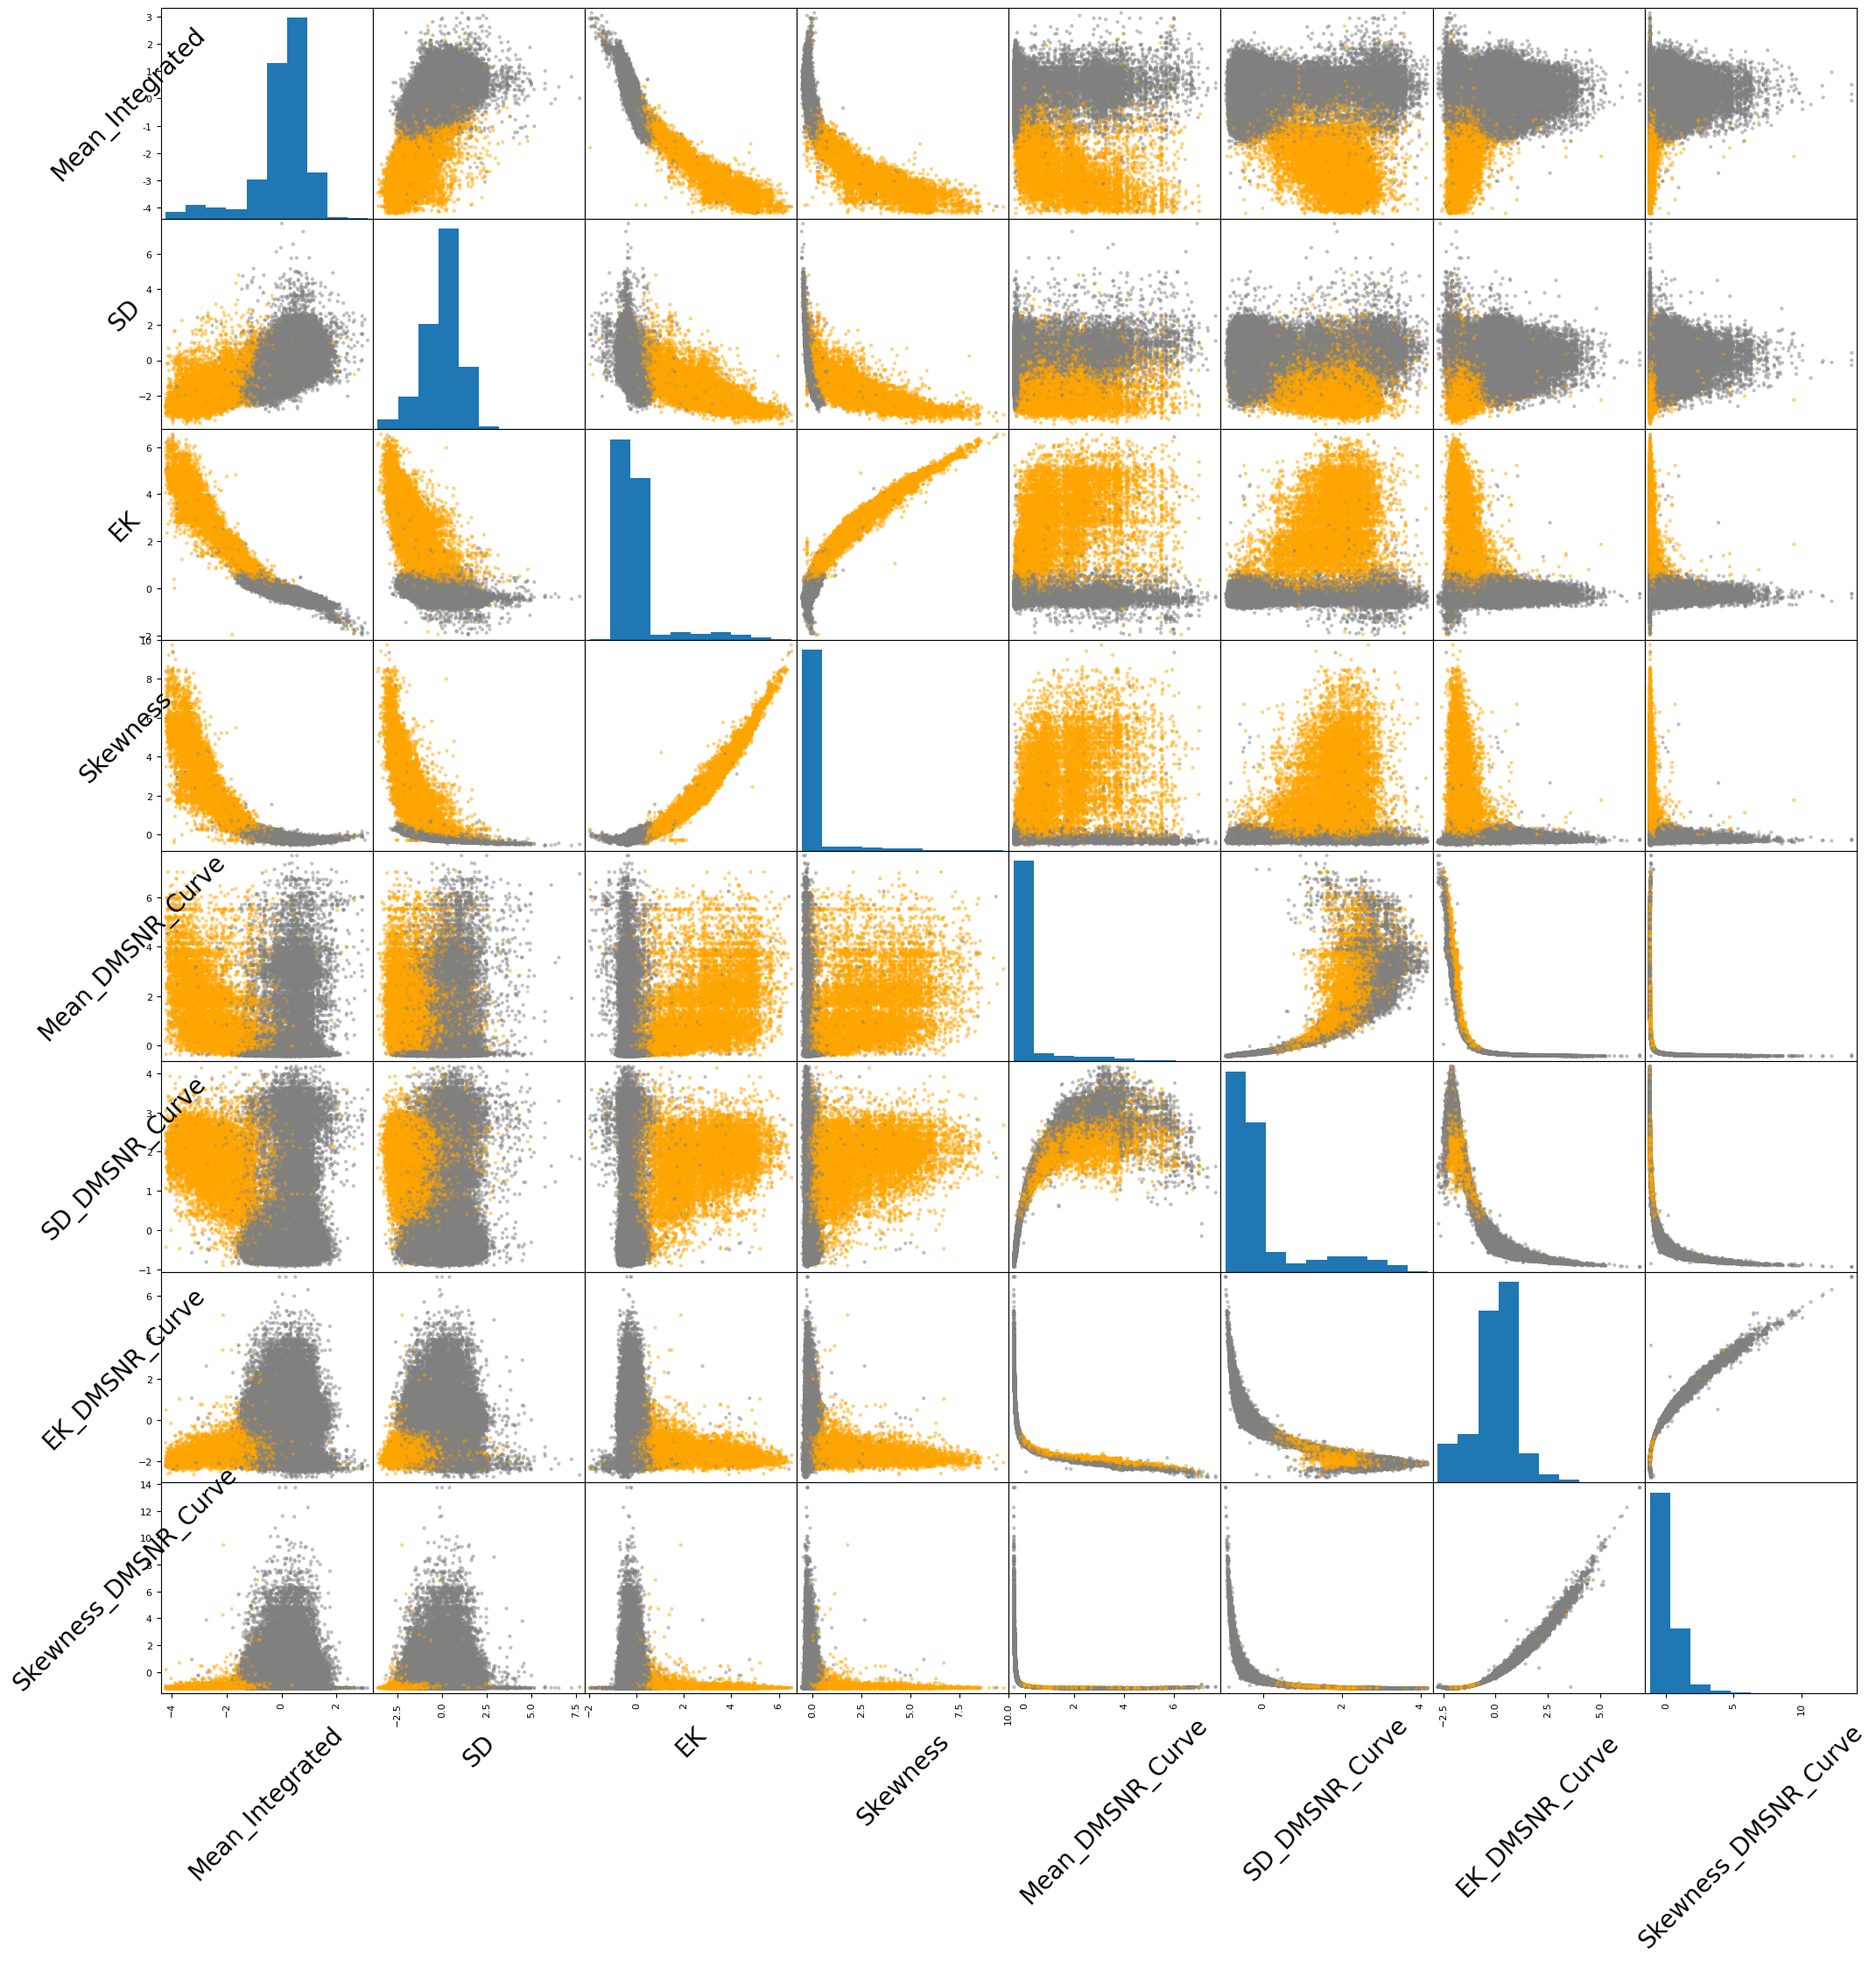

In [4]:
colors = {1: 'orange', 0: 'grey'}

def visual(df):
    
    scatter_matrix = pd.plotting.scatter_matrix(
        df, alpha = 0.5, figsize = (25, 25),
        grid = True, marker = '.',
        c = label.map(colors)) 

    for ax in scatter_matrix.ravel():
        ax.set_xlabel(ax.get_xlabel(), fontsize = 20, rotation = 45)
        ax.set_ylabel(ax.get_ylabel(), fontsize = 20, rotation = 45)
    
    return scatter_matrix

visual(train)

Dimensionality reduction by concatenating EK and Skewness, also their DMSNR Curves



In [5]:
SDC = np.array(train['Skewness_DMSNR_Curve']).reshape(-1, 1)
EDC = np.array(train['EK_DMSNR_Curve']).reshape(-1, 1)

EK = np.array(train['EK']).reshape(-1, 1)
SK = np.array(train['Skewness']).reshape(-1, 1)

SDC_EDC = np.concatenate((SDC, EDC), axis=1)
EK_SK = np.concatenate((EK, SK), axis=1)

sdc_edc = PCA(n_components = 1).fit(SDC_EDC)
curves = sdc_edc.transform(SDC_EDC)

ek_sk = PCA(n_components = 1).fit(EK_SK)
eksk = ek_sk.transform(EK_SK)

curves = pd.DataFrame(curves, columns = ['Curves'])
eksk = pd.DataFrame(eksk, columns = ['EKSK'])

del train['Skewness_DMSNR_Curve']
del train['EK_DMSNR_Curve']
del train['EK']
del train['Skewness']

train_new = pd.concat([train, curves, eksk], axis = 1)
train_new.head(10)

Mean_Integrated        SD  Mean_DMSNR_Curve  SD_DMSNR_Curve    Curves  \
0         0.880240  2.130547          1.607581        2.190105 -2.177576   
1        -0.969814 -1.713208         -0.319826       -0.215829 -0.548045   
2         0.055902 -1.129811         -0.345517       -0.523953 -0.044074   
3         0.378674 -0.130280         -0.346800       -0.261254 -0.181289   
4         0.916312  1.803494         -0.406255       -0.745222  3.385836   
5         0.818446  0.958505         -0.365575       -0.531550  0.211218   
6        -0.012479 -0.844937         -0.374149       -0.449021  0.654025   
7         0.359540  0.526694         -0.324958       -0.389876 -0.112989   
8         0.046806  0.037086         -0.322830       -0.212613 -0.317108   
9        -0.457270  0.225409         -0.319920       -0.100229 -0.269157   

       EKSK  
0 -0.569884  
1 -0.001475  
2 -0.182336  
3 -0.581120  
4 -0.650444  
5 -0.621630  
6 -0.263667  
7 -0.611942  
8 -0.326869  
9 -0.054823

Let's see new picture of that Pulsars

array([[<AxesSubplot:xlabel='Mean_Integrated', ylabel='Mean_Integrated'>,
        <AxesSubplot:xlabel='SD', ylabel='Mean_Integrated'>,
        <AxesSubplot:xlabel='Mean_DMSNR_Curve', ylabel='Mean_Integrated'>,
        <AxesSubplot:xlabel='SD_DMSNR_Curve', ylabel='Mean_Integrated'>,
        <AxesSubplot:xlabel='Curves', ylabel='Mean_Integrated'>,
        <AxesSubplot:xlabel='EKSK', ylabel='Mean_Integrated'>],
       [<AxesSubplot:xlabel='Mean_Integrated', ylabel='SD'>,
        <AxesSubplot:xlabel='SD', ylabel='SD'>,
        <AxesSubplot:xlabel='Mean_DMSNR_Curve', ylabel='SD'>,
        <AxesSubplot:xlabel='SD_DMSNR_Curve', ylabel='SD'>,
        <AxesSubplot:xlabel='Curves', ylabel='SD'>,
        <AxesSubplot:xlabel='EKSK', ylabel='SD'>],
       [<AxesSubplot:xlabel='Mean_Integrated', ylabel='Mean_DMSNR_Curve'>,
        <AxesSubplot:xlabel='SD', ylabel='Mean_DMSNR_Curve'>,
        <AxesSubplot:xlabel='Mean_DMSNR_Curve', ylabel='Mean_DMSNR_Curve'>,
        <AxesSubplot:xlabel='SD_DMSNR_Cur

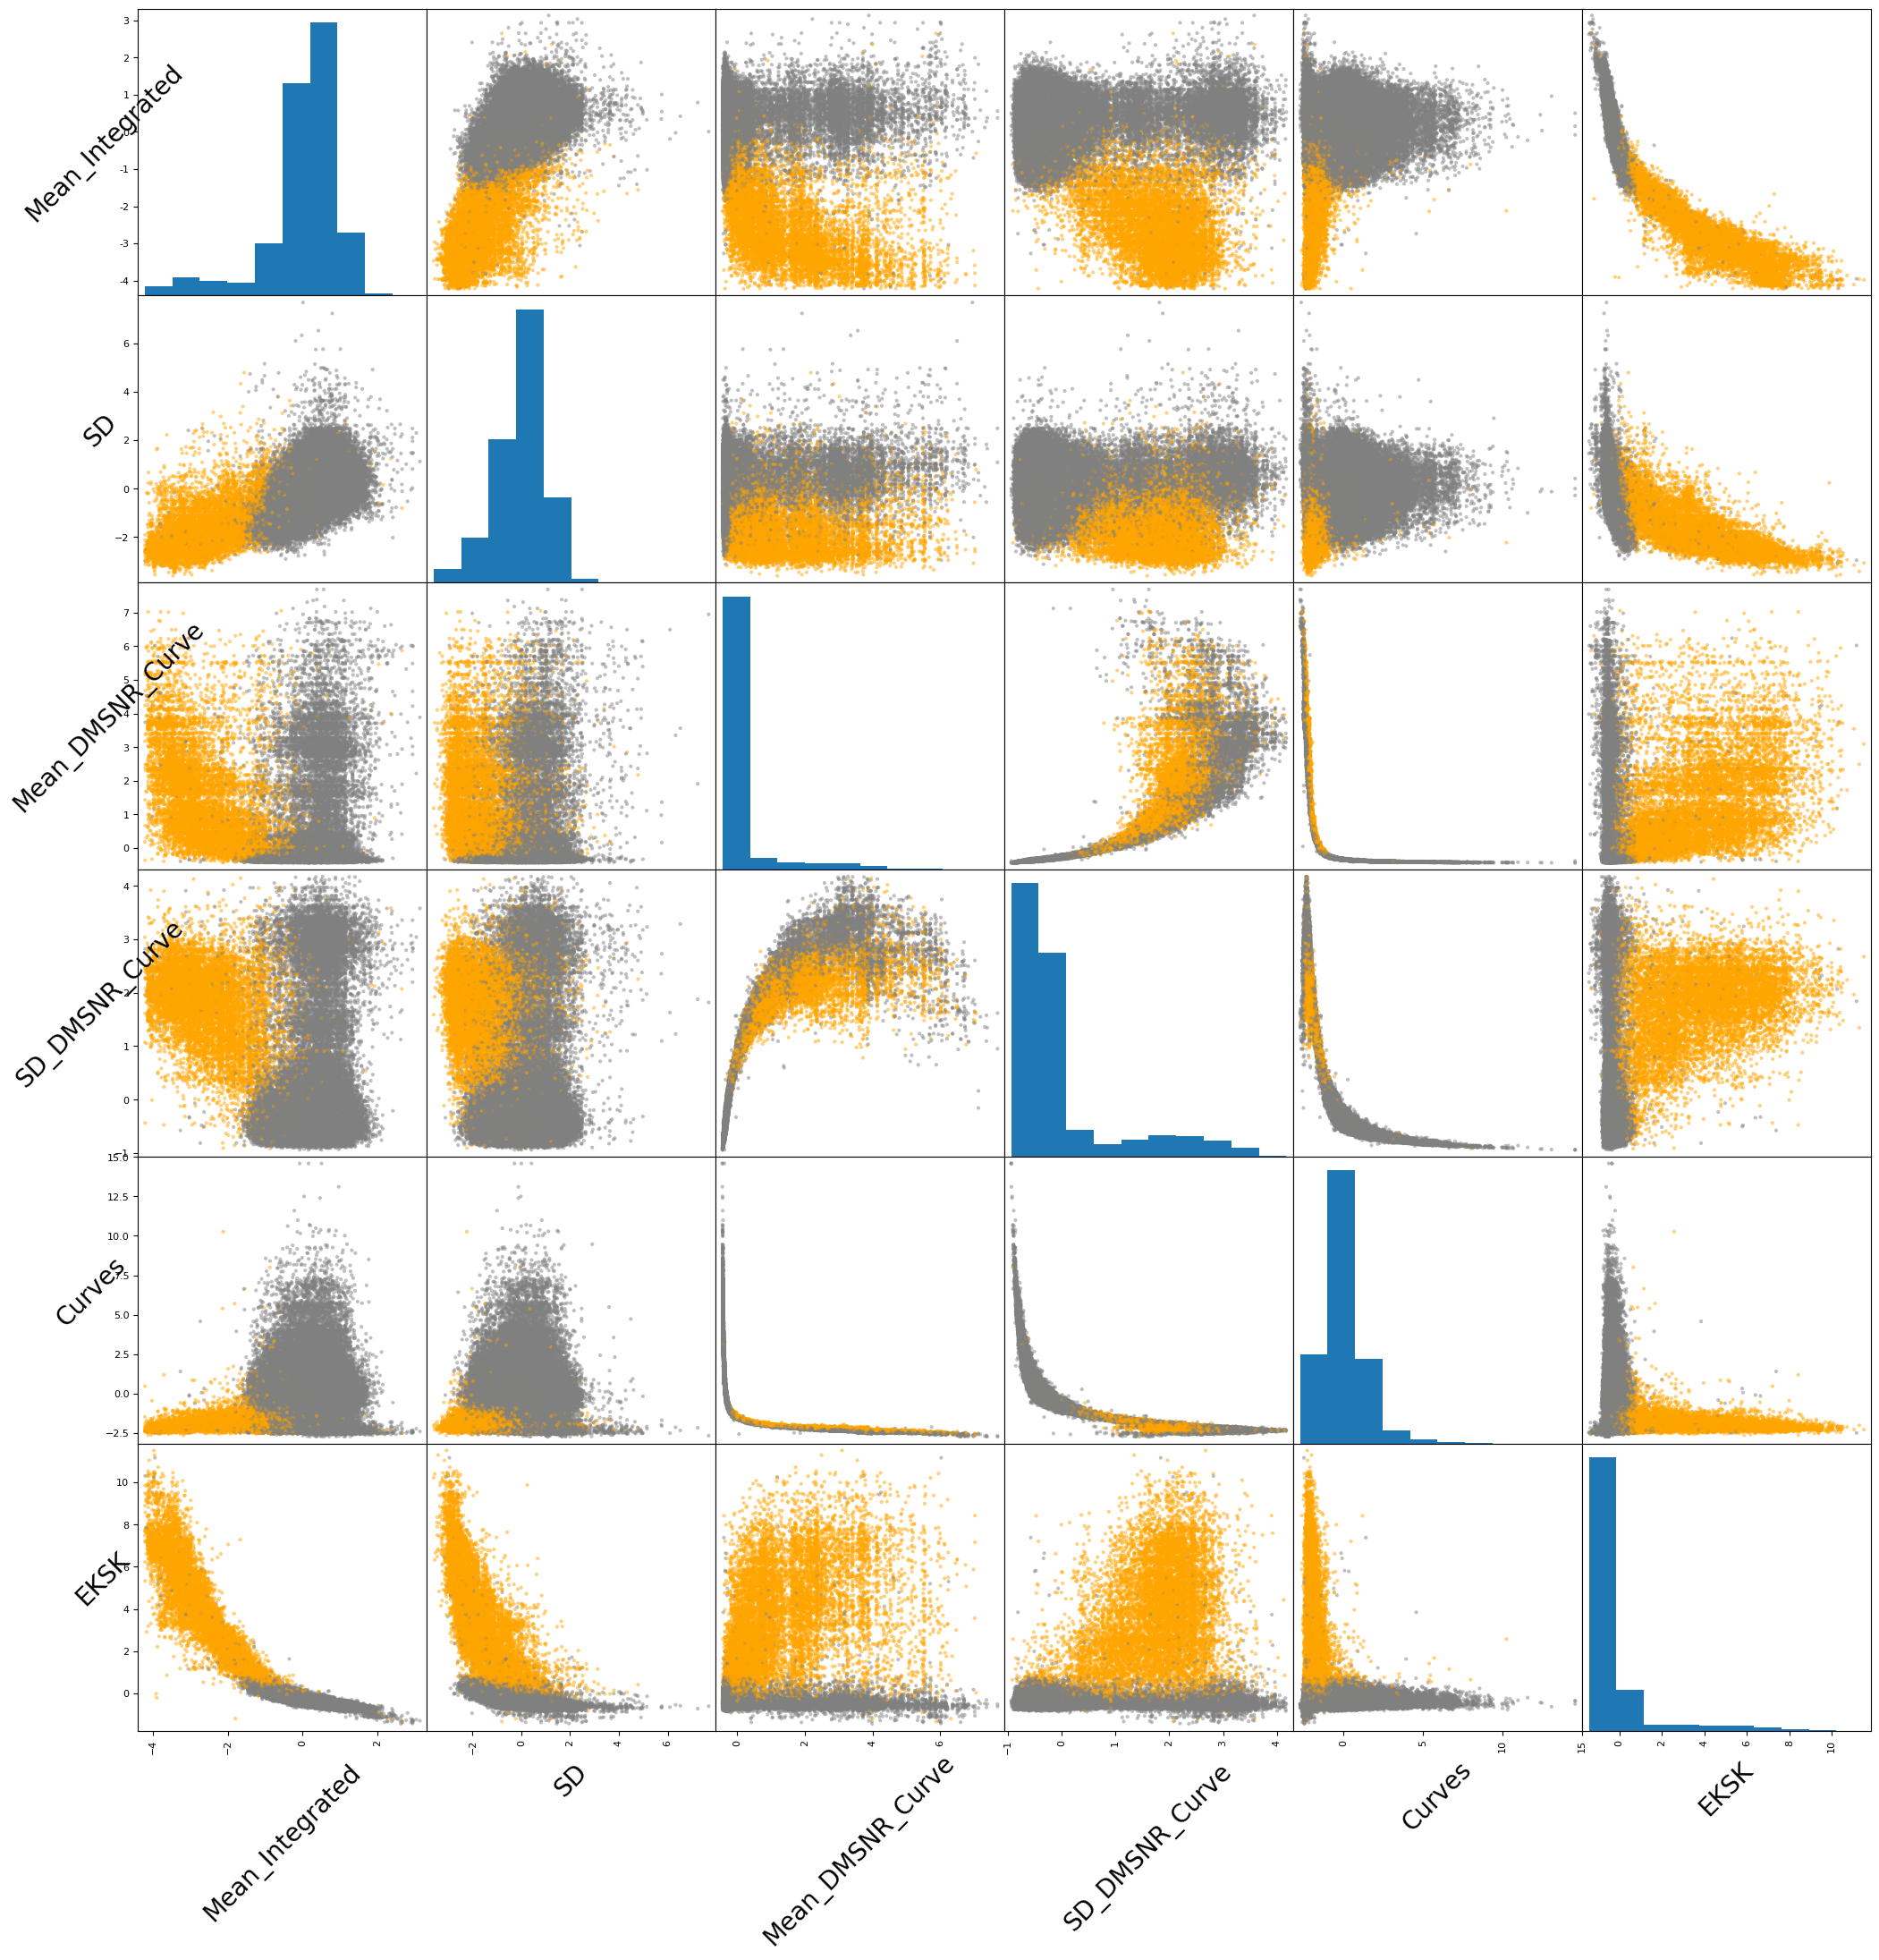

In [6]:
visual(train_new)

And some of them in 3D

In [7]:
class scatter_3D:
    
    def __init__(self, x, y, z):
        
        self.x = x
        self.y = y
        self.z = z
        
    def show(self):
        
        x = self.x
        y = self.y
        z = self.z
        
        fig = plt.figure()
        ax = fig.add_subplot(projection = '3d') 
        ax.scatter(x, y, z, alpha = 0.2,
               c = label.map(colors)) 
        ax.set_xlabel('X label') 
        ax.set_ylabel('Y label') 
        ax.set_zlabel('Z label')
        
        return plt.show()

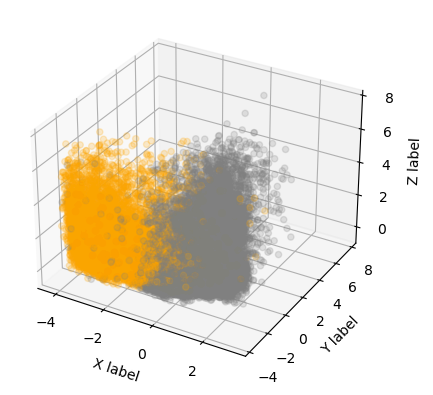

In [8]:
pack_0 = scatter_3D(train_new['Mean_Integrated'],
                    train_new['SD'], 
                    train_new['Mean_DMSNR_Curve'])
pack_0.show()

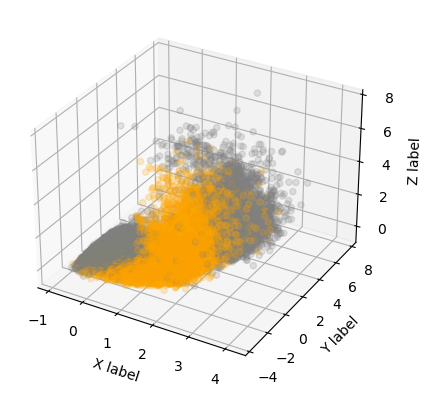

In [9]:
pack_1 = scatter_3D(train_new['SD_DMSNR_Curve'],
                    train_new['SD'], 
                    train_new['Mean_DMSNR_Curve'])
pack_1.show()

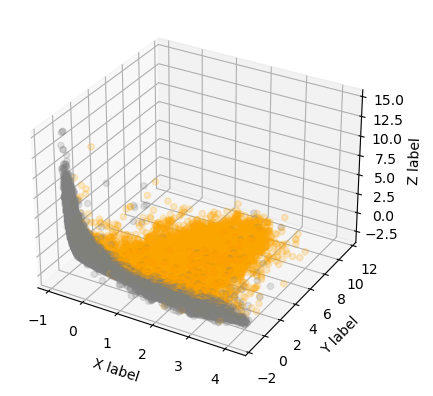

In [10]:
pack_3 = scatter_3D(train_new['SD_DMSNR_Curve'],
                    train_new['EKSK'], 
                    train_new['Curves'])
pack_3.show()

Oh, i guess, i find difficult pair,
I will test my models on that pair.
But, at first, i'll split dataset

In [11]:
x_train, x_test, y_train, y_test = train_test_split(train_new, label, 
                                                    test_size = 0.2, random_state = 17)
x_train

Mean_Integrated        SD  Mean_DMSNR_Curve  SD_DMSNR_Curve    Curves  \
88068         -0.022203  0.781685         -0.328963       -0.244691 -0.354118   
65743          0.080055  0.357174         -0.325459       -0.064509 -0.364739   
30507          0.154083 -0.104655         -0.352996       -0.524283  0.149156   
52184          0.059039 -0.071869         -0.370081       -0.426321  0.237440   
93865         -0.509340 -0.159990         -0.329527       -0.212740 -0.072928   
...                 ...       ...               ...             ...       ...   
98710          1.165684  1.067100         -0.366326       -0.478929  0.549215   
112006        -0.382615 -1.571654         -0.338038       -0.467400 -0.015390   
34959         -0.057021 -0.307711         -0.337882       -0.268770 -0.189739   
64753          0.139967 -0.442823         -0.299674       -0.238463 -0.577592   
76399          0.819387  0.328162         -0.400215       -0.703323  2.067157   

            EKSK  
88068  -0.401297  
65743  -0.225297  
30507  -0.414498  
52184  -0.316930  
93865  -0.069192  
...          ...  
98710  -0.694767  
112006 -0.050894  
34959  -0.341421  
64753  -0.244537  
76399  -0.532823  

[94051 rows x 6 columns]

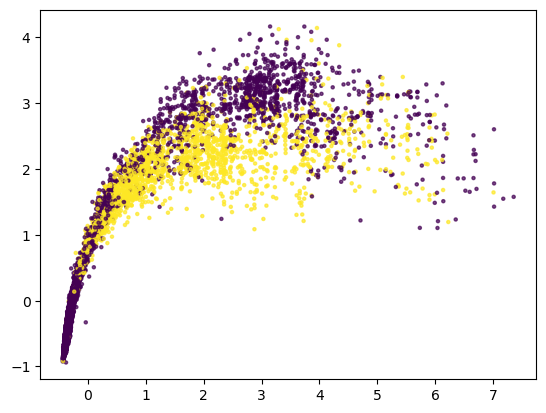

In [12]:
sub_train = pd.DataFrame(x_train, columns = ['Mean_DMSNR_Curve', 'SD_DMSNR_Curve'])
sub_test = pd.DataFrame(x_test, columns = ['Mean_DMSNR_Curve', 'SD_DMSNR_Curve'])

b = plt.scatter(sub_test['Mean_DMSNR_Curve'], sub_test['SD_DMSNR_Curve'],
            s = 5, alpha = 0.7, marker = 'o', c = y_test)
plt.show(b)

Oh yeah, it looks like fontain, let test model  on that spread

In [17]:
def result(model):
    
    pred = model.predict(sub_test)
    accuracy = log_loss(y_test, pred)
    print(f':loss sub_test {accuracy}')

    a = plt.scatter(sub_test['Mean_DMSNR_Curve'], sub_test['SD_DMSNR_Curve'],
            s = 5, alpha = 0.7, marker = 'o', c = pred)
    plt.show(a)

    b = plt.scatter(sub_test['Mean_DMSNR_Curve'], sub_test['SD_DMSNR_Curve'],
            s = 5, alpha = 0.7, marker = 'o', c = y_test)
    plt.show(b)

First - CatBoostClassifier

:loss sub_test 1.6628350404086572


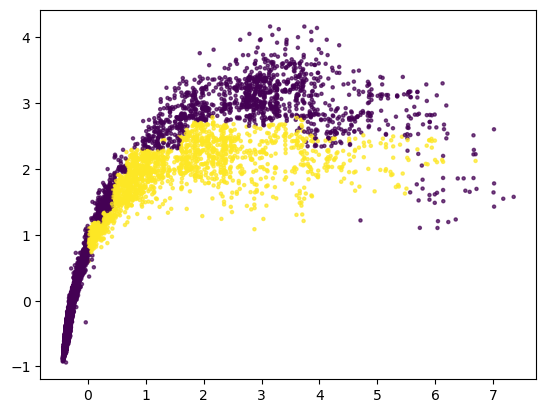

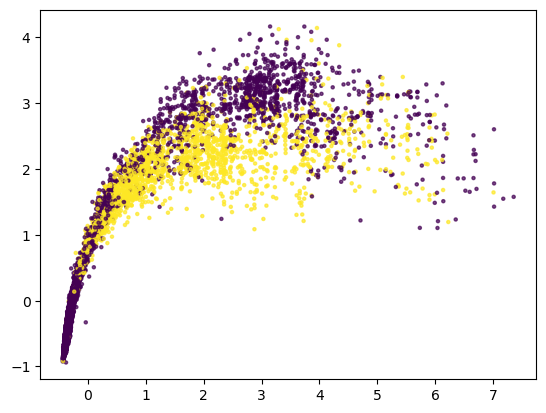

In [18]:
model_0 = CatBoostClassifier(
    iterations = 618, 
    learning_rate = 0.345,
    random_seed = 43,
    loss_function = 'Logloss'
)

model_0.fit(
    sub_train, y_train,
    eval_set = (sub_test, y_test),
    verbose = False,
    )

result(model_0)

Now, classic KNeighbors

:loss sub_test 1.6995585467515042


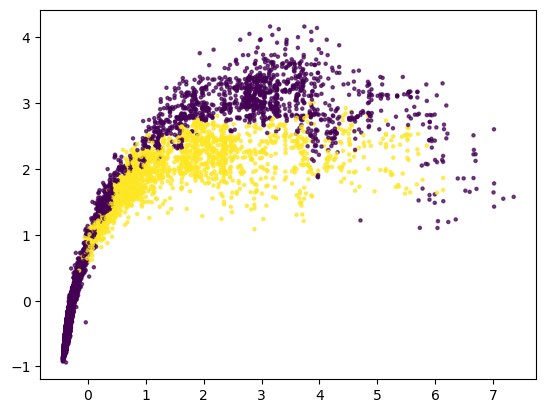

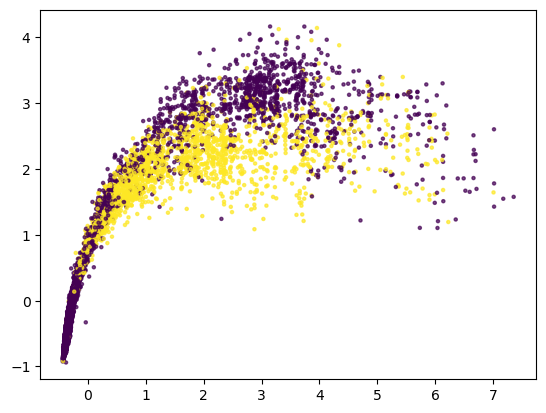

In [19]:
model_1 = KNeighborsClassifier(n_neighbors=13).fit(sub_train, y_train)

result(model_1)

RandomForest

:loss sub_test 1.6496142951902335


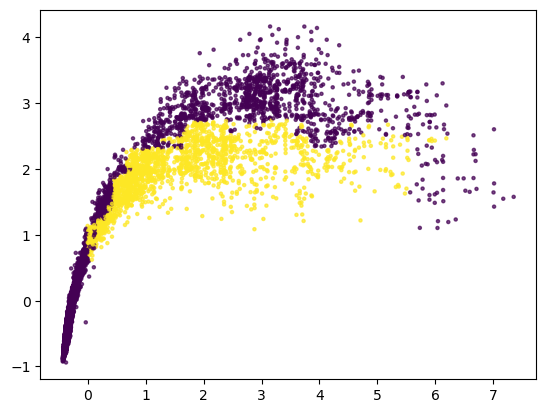

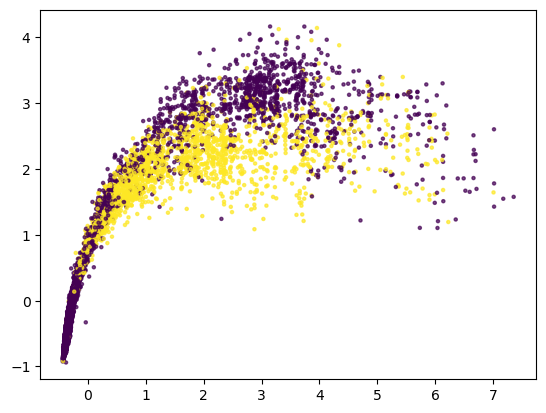

In [20]:
model_2 = RandomForestClassifier(n_estimators=285,     
                               criterion='gini',
                               max_depth=17,                    
                               max_features=None,
                               min_weight_fraction_leaf=0.001,
                               random_state=1337,
                               ).fit(sub_train, y_train)

result(model_2)

Ok, of that 3 guys, Random forest is the best, but...
Lets test DenseNN, i belive in that

Epoch 1/10
184/184 [==============================] - 3s 9ms/step - loss: 0.1804 - accuracy: 0.9138
Epoch 2/10
184/184 [==============================] - 2s 9ms/step - loss: 0.1409 - accuracy: 0.9346
Epoch 3/10
184/184 [==============================] - 2s 9ms/step - loss: 0.1289 - accuracy: 0.9440
Epoch 4/10
184/184 [==============================] - 2s 9ms/step - loss: 0.1265 - accuracy: 0.9453
Epoch 5/10
184/184 [==============================] - 2s 9ms/step - loss: 0.1265 - accuracy: 0.9459
Epoch 6/10
184/184 [==============================] - 2s 9ms/step - loss: 0.1262 - accuracy: 0.9460
Epoch 7/10
184/184 [==============================] - 2s 9ms/step - loss: 0.1248 - accuracy: 0.9466
Epoch 8/10
184/184 [==============================] - 2s 9ms/step - loss: 0.1253 - accuracy: 0.9469
Epoch 9/10
184/184 [==============================] - 2s 9ms/step - loss: 0.1246 - accuracy: 0.9469
Epoch 10/10
735/735 [==============================] - 2s 2ms/step
:loss sub_test 0.1232934288787309

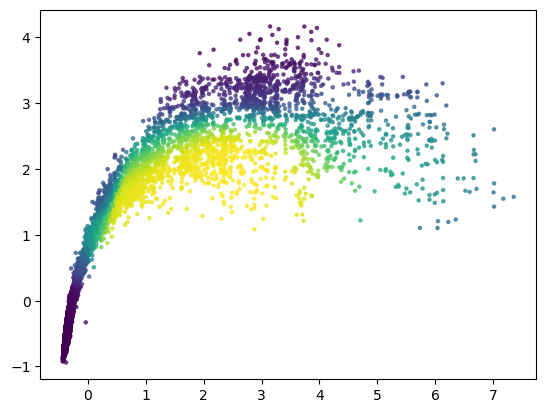

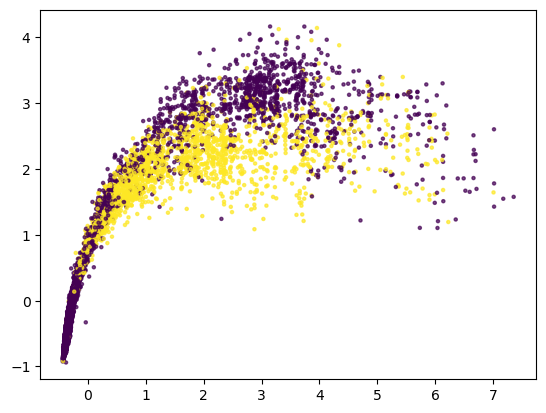

In [43]:
model = keras.Sequential([
        layers.Dense(256, activation = "relu"),
        layers.Dropout(0.25),
        layers.Dense(128, activation = "relu"),
        layers.Dropout(0.25),
        layers.Dense(64, activation = "relu"),
        layers.Dense(32, activation = "relu"),
        layers.Dense(16, activation = "relu"),
        layers.Dense(1, activation = "sigmoid")
    ])

model.compile(optimizer = "Adam",
             loss = "binary_crossentropy",
             metrics = ["accuracy"])

model.fit(sub_train, y_train,
          epochs = 10, batch_size = 512)
    
pred = model.predict(sub_test)
accuracy = log_loss(y_test, pred)
print(f':loss sub_test {accuracy}')

a = plt.scatter(sub_test['Mean_DMSNR_Curve'], sub_test['SD_DMSNR_Curve'],
                s = 5, alpha = 0.7, marker = 'o', c = pred)
plt.show(a)

b = plt.scatter(sub_test['Mean_DMSNR_Curve'], sub_test['SD_DMSNR_Curve'],
                s = 5, alpha = 0.7, marker = 'o', c = y_test)
plt.show(b)

Good, let test it on full dataset

In [45]:
model_f = keras.Sequential([
        layers.Dense(256, activation = "relu"),
        layers.Dropout(0.25),
        layers.Dense(128, activation = "relu"),
        layers.Dropout(0.25),
        layers.Dense(64, activation = "relu"),
        layers.Dense(32, activation = "relu"),
        layers.Dense(16, activation = "relu"),
        layers.Dense(1, activation = "sigmoid")
    ])

model_f.compile(optimizer = "Adam",
                loss = "binary_crossentropy",
                metrics = ["accuracy"])

model_f.fit(x_train, y_train,
          epochs = 10, batch_size = 512)
    
pred_f = model_f.predict(x_test)
accuracy_f = log_loss(y_test, pred_f)
print(f':loss sub_test {accuracy}')

Epoch 1/10
184/184 [==============================] - 3s 10ms/step - loss: 0.0753 - accuracy: 0.9834
Epoch 2/10
184/184 [==============================] - 2s 10ms/step - loss: 0.0374 - accuracy: 0.9900
Epoch 3/10
184/184 [==============================] - 2s 10ms/step - loss: 0.0361 - accuracy: 0.9900
Epoch 4/10
184/184 [==============================] - 2s 10ms/step - loss: 0.0352 - accuracy: 0.9902
Epoch 5/10
184/184 [==============================] - 2s 9ms/step - loss: 0.0347 - accuracy: 0.9903
Epoch 6/10
184/184 [==============================] - 2s 10ms/step - loss: 0.0347 - accuracy: 0.9904
Epoch 7/10
184/184 [==============================] - 2s 10ms/step - loss: 0.0341 - accuracy: 0.9906
Epoch 8/10
184/184 [==============================] - 2s 9ms/step - loss: 0.0343 - accuracy: 0.9904
Epoch 9/10
184/184 [==============================] - 2s 9ms/step - loss: 0.0340 - accuracy: 0.9906
Epoch 10/10
735/735 [==============================] - 1s 2ms/step
:loss sub_test 0.1232934288

Good, let make prediction on test dataset

In [42]:
#Preparing test data

test = pd.read_csv('/kaggle/input/playground-series-s3e10/test.csv')

del test['id']

scaler = StandardScaler()
test = pd.DataFrame(scaler.fit_transform(test),columns = test.columns)

SDC_T = np.array(test['Skewness_DMSNR_Curve']).reshape(-1, 1)
EDC_T = np.array(test['EK_DMSNR_Curve']).reshape(-1, 1)

EK_T = np.array(test['EK']).reshape(-1, 1)
SK_T = np.array(test['Skewness']).reshape(-1, 1)

SDC_EDC_T = np.concatenate((SDC_T, EDC_T), axis=1)
EK_SK_T = np.concatenate((EK_T, SK_T), axis=1)

sdc_edc_T = PCA(n_components = 1).fit(SDC_EDC_T)
curves_T = sdc_edc_T.transform(SDC_EDC_T)

ek_sk_T = PCA(n_components = 1).fit(EK_SK_T)
eksk_T = ek_sk_T.transform(EK_SK_T)

curves_T = pd.DataFrame(curves_T, columns = ['Curves'])
eksk_T = pd.DataFrame(eksk_T, columns = ['EKSK'])

del test['Skewness_DMSNR_Curve']
del test['EK_DMSNR_Curve']
del test['EK']
del test['Skewness']

test = pd.concat([test, curves_T, eksk_T], axis = 1)
test.head(10)

Mean_Integrated        SD  Mean_DMSNR_Curve  SD_DMSNR_Curve    Curves  \
0         1.163531  1.277518         -0.357746       -0.562333  0.497203   
1        -0.141825  0.796456         -0.386433       -0.681096  1.458582   
2         0.961587  0.506288         -0.311180       -0.242456 -0.456949   
3         0.060119 -0.788937         -0.194953        0.147408 -1.137593   
4        -0.612501 -1.873649         -0.362239       -0.453312  0.521821   
5        -2.623712 -1.425212          0.393501        1.644302 -1.848035   
6         1.301537  0.159666         -0.340559       -0.332995 -0.143923   
7         0.108547 -0.518994         -0.263608       -0.101321 -0.707373   
8         1.088831  0.416850         -0.215094        0.391833 -1.114812   
9         0.301312  0.999910         -0.329341       -0.306699 -0.167585   

       EKSK  
0 -0.542679  
1 -0.373901  
2 -0.583756  
3 -0.044372  
4  0.058664  
5  3.272266  
6 -0.552040  
7 -0.145769  
8 -0.656164  
9 -0.452237

Finally...

In [73]:
prediction = model_f.predict(test)

submission = pd.read_csv('/kaggle/input/playground-series-s3e10/test.csv')
submission = pd.DataFrame(submission['id'])
Class = pd.DataFrame(data=prediction, columns = ['Class'])
submission = pd.concat([submission, Class], axis = 1)
submission.to_csv('/kaggle/working/submission.csv', index = False)
submission.head(5)

2450/2450 [==============================] - 5s 2ms/step


id     Class
0  117564  0.000208
1  117565  0.002572
2  117566  0.000147
3  117567  0.045420
4  117568  0.003695